In [1]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, math, random, PIL, time, copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from collections import defaultdict



In [2]:
def timer_start():
    global t0
    t0 = time.time()
    
def timer_end():   
    print('Time elapsed {:0.1f}s'.format(time.time() - t0))  

def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()
    
def get_best_epcoh(history):
    valid_acc = history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) +1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

def plot_results(history):
    tr_acc = history['tr_acc']
    val_acc = history['val_acc']
    tr_loss = history['tr_loss']
    val_loss = history['val_loss']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)


## Class Swift

In [3]:
base_dir = '/kaggle/input/cars-wagonr-swift/data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation' )

train_swift = os.listdir(os.path.join(base_dir, 'train/swift') )
val_swift  = os.listdir(os.path.join(base_dir, 'validation/swift') )
test_swift  =  os.listdir(os.path.join(base_dir, 'test/swift') )
print('Instances for Class Swift: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Swift: Train 1200, Validation 400 Test 400


In [4]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_swift if x in train_swift]
test_train = [x for x in test_swift if x in train_swift]
val_test =  [x for x in test_swift if x in val_swift]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

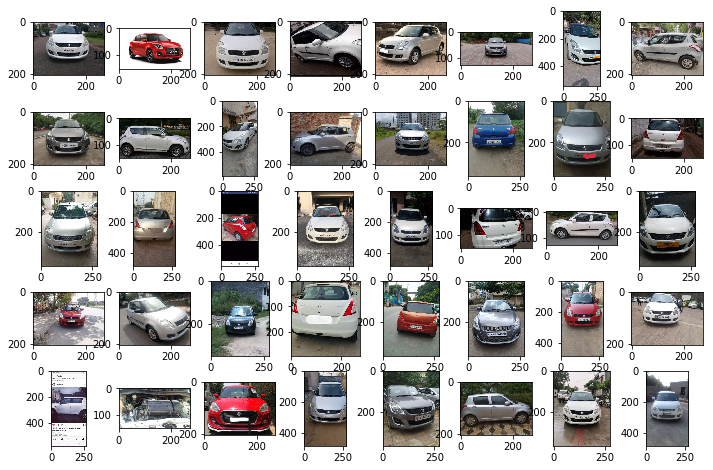

In [5]:
display_grid(data = train_swift, path = os.path.join(base_dir, 'train/swift'), w =10, h =10, columns = 8, rows = 5)

## Class Wagonr

In [6]:
train_wr = os.listdir(os.path.join(base_dir, 'train/wagonr') )
val_wr  = os.listdir(os.path.join(base_dir, 'validation/wagonr') )
test_wr  =  os.listdir(os.path.join(base_dir, 'test/wagonr') )
print('Instances for Class Wagonr: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Wagonr: Train 1200, Validation 400 Test 400


In [7]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_wr if x in train_wr]
test_train = [x for x in test_wr if x in train_wr]
val_test =  [x for x in test_wr if x in val_wr]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

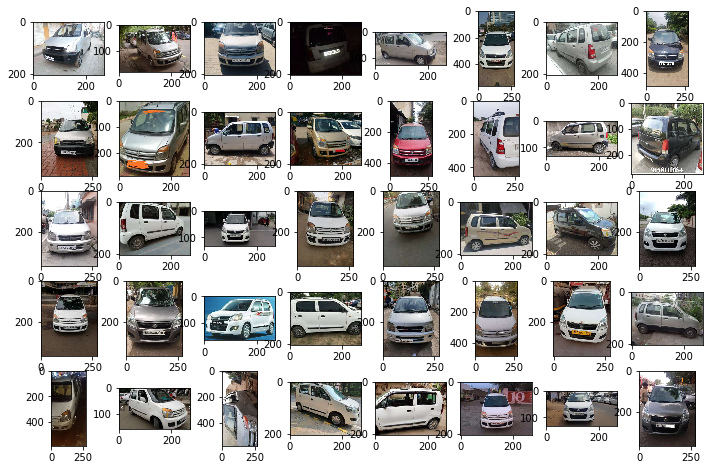

In [8]:
display_grid(data = train_wr, path = os.path.join(base_dir, 'train/wagonr'), w =10, h =10, columns = 8, rows = 5)

## Data Preprocessing With Augmentaion

#### An example of Augmentation Applied

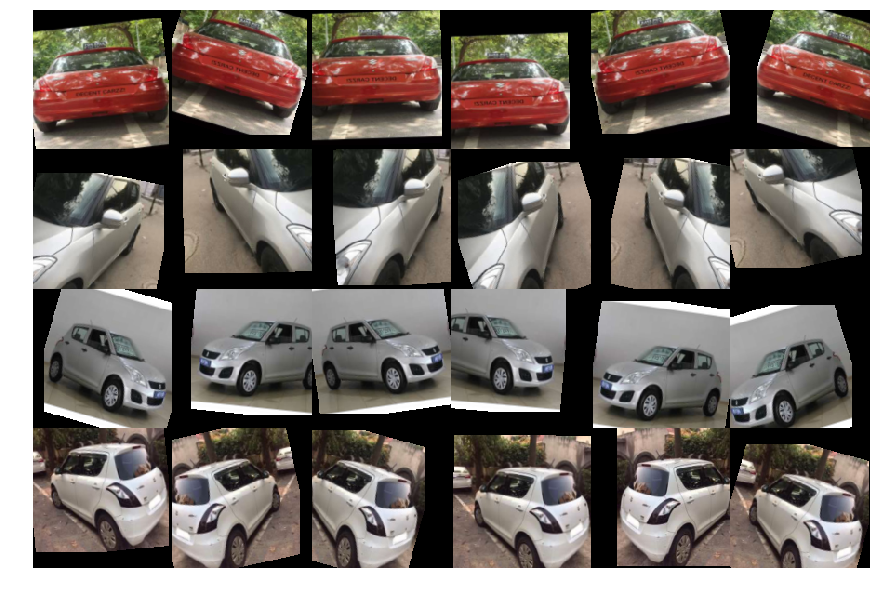

In [9]:

# https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=9NRlYXKQy3Kx
# https://pytorch.org/docs/stable/torchvision/transforms.html
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(4)))
  plt.imshow(img)
  plt.axis('off')

transform_train = transforms.Compose( [                                  
                                 transforms.Resize((150,150)), 
#                                  transforms.RandomCrop(size =100),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                 transforms.ColorJitter(hue= 0.01, saturation=.01),
                                 transforms.RandomAffine(degrees = 0, translate=(0.2,0.2),  shear= 0.2),
                                  ])

trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform= transform_train
                                               )

show_dataset(trainset)
# len(trainset)

In [10]:
# from https://forums.fast.ai/t/normalizing-your-dataset/49799
# Compute the mean and standrad deviation of the training images for each channel. This will be used to normalize the tensors to [-1,1]

transform = transforms.Compose( [                                  
                                 transforms.Resize((150,150)), 
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                 transforms.ColorJitter(hue= 0.01, saturation=.01),
                                 transforms.RandomAffine(degrees = 0, translate=(0.2,0.2),  shear= 0.2),
                                 transforms.ToTensor(),
                                  ])

trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform=transform
                                               )

trainloader = torch.utils.data.DataLoader(trainset, batch_size= 512 ,
                                          shuffle=True, num_workers=1)
mean, std = online_mean_and_sd(trainloader)
print(mean, std)

tensor([0.3494, 0.3392, 0.3309]) tensor([0.2923, 0.2881, 0.2887])


In [11]:


BATCH_SIZE = 20
# transforms.ToTensor() trasnforms the pixels from [0,255] to [0,1] which is then 
# trasnformed to [-1,1] using Normalize with mean computed mean and std for each of three channels
transform_train = transforms.Compose( [                                  
                                     transforms.Resize((150,150)),                                       
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                     transforms.ColorJitter(hue= 0.01, saturation=.01),
                                     transforms.RandomAffine(degrees = 0, translate=(0.2,0.2),  shear= 0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std),
                                  ])



#Validation and test set should not be augumented, hence different transforms
transform_test = transforms.Compose( [                                  
                                 transforms.Resize((150,150)), 
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std),
                                  ])
trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform= transform_train
                                               )


trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=1)


validset = torchvision.datasets.ImageFolder( root= validation_dir ,
                                              transform= transform_test 
                                               )


validloader = torch.utils.data.DataLoader(validset , batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=1)

print(online_mean_and_sd(trainloader))

(tensor([-0.0006, -0.0003, -0.0008]), tensor([1.0005, 1.0005, 1.0002]))


## Build CNN model With BatchNormalization

Droput is not  used and BN is used after  Relu Activation Function

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=32, kernel_size= 3)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride= 2)        
        
        self.conv2 =  nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3)
        self.bn2   = nn.BatchNorm2d(64)
        
        self.conv3 =  nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3)
        self.bn3  = nn.BatchNorm2d(128)
        
        self.conv4 =  nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 3)
        self.bn4  = nn.BatchNorm2d(128)
    
#       128 * 128 * 7 is the output of the last max pool layer
        self.fc1 = nn.Linear(128 * 7 * 7, 512)       
        self.bn5= nn.BatchNorm1d(512)
        
        #Final Oyput layer
        self.fc2 = nn.Linear(512, 2)
       
       

    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        
        x = self.conv2(x) 
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        
        x = self.conv3(x)        
        x = F.relu(x)  
        x = self.bn3(x)
        x = self.pool(x)
        
        x = self.conv4(x)        
        x = F.relu(x)   
        x = self.bn4(x)
        x = self.pool(x)   

        #this is similar to flatten in keras but keras is smart to figure out dimensions by iteself.
        x = x.view(-1, 128 * 7 * 7)   
        
        x = self.fc1(x)        
        x = F.relu(x)  
        x = self.bn5(x)
        x = self.fc2(x)
       
        return x



## Train Model

### Custom Train and Test Function

In [13]:
def train(model, epoch, train_loader, optimizer, criterion) :   
    model.train()
    epoch_loss = correct = 0
    for i, data in enumerate(train_loader, 0):
        # Load images with gradient accumulation capabilities
        inputs, labels = data[0].to(device), data[1].to(device)
        # Clear gradients w.r.t. parameters       
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(inputs)

         # Calculate Loss: softmax --> cross entropy loss
        loss =  criterion(outputs, labels)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)           

        # Total correct predictions 
        correct += (predicted == labels).sum().item()  

        # Getting gradients w.r.t. parameters
        loss.backward()

         # Updating parameters
        optimizer.step() 
        
        #Multiple loss by number of batch as loss is averaged per batch
        epoch_loss += outputs.shape[0] * loss.item()
        
    accuracy = correct / len(train_loader.dataset)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    return epoch_loss, accuracy


def test(model, epoch, test_loader, optimizer, criterion):
    model.eval()
    epoch_loss = correct = 0
  
    with torch.no_grad():
        #Iterate through test dataset after every epoch
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass only to get logits/output
            outputs = model(images)

            # Calculate Validation Loss
            loss =    criterion(outputs, labels)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)           

            # Total correct predictions 
            correct += (predicted == labels).sum().item()  

             #Multiple loss by number of batch as loss is averaged per batch so that we get
            #total loss over an epoch and then divide by number of samples to get loss per epcoh
            epoch_loss += outputs.shape[0] * loss.item()

    
    accuracy = correct / len(test_loader.dataset)
    epoch_loss = epoch_loss / len(test_loader.dataset)
  
    return epoch_loss, accuracy 


### Set Loss Function and Optimizers

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
print('Divice: ',device)
model


Divice:  cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

### Train and Validate

In [15]:
%%time
EPOCHS = 150

#To get reprodicible results but not working at mommnet
# set_seed(42)

train_list  = os.listdir(os.path.join(base_dir, 'train/swift') ) + os.listdir(os.path.join(base_dir, 'train/wagonr') )
num_batches = math.ceil(len(train_list) / BATCH_SIZE)

print('Number of Training samples {}, Batch Size {}, Num Batch {}'.format( len(train_list), BATCH_SIZE, num_batches ))

history = defaultdict(list)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0

# Get Keras like outputs for Training and validation by using custom train and test functions.
# Retain the best model based on Validation score
for epoch in range( EPOCHS):  
    timer_start()
    
    
    print('[Epoch {} of {}]'.format(epoch +1, EPOCHS),end = ' ')
    tr_loss, tr_acc = train(model, epoch, trainloader, optimizer, criterion)

    val_loss, val_acc = test(model, epoch, validloader, optimizer, criterion)  
    
#   Copy the best model
    if val_acc > best_acc:
       best_acc = val_acc
       best_model_wts = copy.deepcopy(model.state_dict())
        
    timer_end()
    print('tr_loss: {:0.4f},tr_acc {:0.4f}| val_loss {:0.4f}, val_acc {:0.4f}'.format(tr_loss, tr_acc , val_loss, val_acc))
    history['epoch'].append(epoch+1)
    history['tr_loss'].append(round(tr_loss,5))
    history['tr_acc'].append(round(tr_acc,5))
    history['val_loss'].append(round(val_loss,5))
    history['val_acc'].append(round(val_acc,5))

# load best model weights
model.load_state_dict(best_model_wts)

Number of Training samples 2400, Batch Size 20, Num Batch 120
[Epoch 1 of 150] Time elapsed 20.6s
tr_loss: 0.7717,tr_acc 0.5842| val_loss 0.7433, val_acc 0.5988
[Epoch 2 of 150] Time elapsed 20.0s
tr_loss: 0.6434,tr_acc 0.6462| val_loss 0.5811, val_acc 0.6975
[Epoch 3 of 150] Time elapsed 20.0s
tr_loss: 0.5935,tr_acc 0.6871| val_loss 0.5654, val_acc 0.7362
[Epoch 4 of 150] Time elapsed 20.0s
tr_loss: 0.5640,tr_acc 0.7100| val_loss 0.5623, val_acc 0.7438
[Epoch 5 of 150] Time elapsed 20.0s
tr_loss: 0.4946,tr_acc 0.7554| val_loss 0.5854, val_acc 0.7225
[Epoch 6 of 150] Time elapsed 20.1s
tr_loss: 0.4552,tr_acc 0.7879| val_loss 0.4095, val_acc 0.8225
[Epoch 7 of 150] Time elapsed 19.9s
tr_loss: 0.4283,tr_acc 0.7867| val_loss 0.3726, val_acc 0.8287
[Epoch 8 of 150] Time elapsed 20.0s
tr_loss: 0.3935,tr_acc 0.8167| val_loss 0.3321, val_acc 0.8462
[Epoch 9 of 150] Time elapsed 19.7s
tr_loss: 0.3720,tr_acc 0.8254| val_loss 0.5060, val_acc 0.7987
[Epoch 10 of 150] Time elapsed 20.1s
tr_loss: 0

<All keys matched successfully>

## Plot Training vs Validation results[](http://)

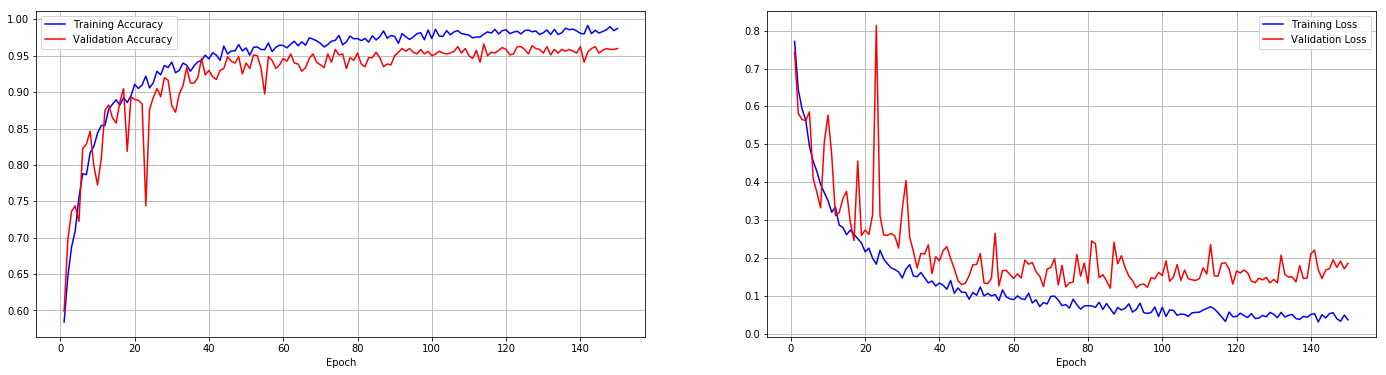

Best Validation Accuracy Score 0.96625, is for epoch 114


In [16]:

plot_results(history)
best_epoch = get_best_epcoh(history)

## Predict on Best Model

In [17]:
def predict(model, loader):
    model.eval()   
    correct = 0
    with torch.no_grad():
        #Iterate through test dataset after every epoch
        for i, data in enumerate(loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass only to get logits/output
            outputs = model(images)     

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)           

            # Total correct predictions 
            correct += (predicted == labels).sum().item()        

    accuracy = correct / len(loader.dataset)
    return accuracy

In [18]:
predict(model, validloader)

0.96625